# 1. Install and setup

In [1]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
# https://github.com/tensorflow/tensorflow/issues/33721 

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
import seaborn as sns
import time
from csv import QUOTE_NONE
from ipywidgets import IntProgress

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
print(tf.__version__)

2.4.1


# 2. Exploratory Data Analysis

In [5]:
# There are more than 550k samples in total; we will use 100k for this example.
train_df = pd.read_csv("../snli_1.0_train.csv")
valid_df = pd.read_csv("../snli_1.0_dev.csv")
test_df = pd.read_csv("../snli_1.0_test.csv")

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {valid_df.shape[0]}")
print(f"Total test samples: {test_df.shape[0]}")

Total train samples : 550152
Total validation samples: 10000
Total test samples: 10000


In [6]:
train_df.count()

similarity    550152
sentence1     550152
sentence2     550146
dtype: int64

In [7]:
train_df.dropna(subset=['sentence2'], inplace=True)
train_df.count()

similarity    550146
sentence1     550146
sentence2     550146
dtype: int64

In [8]:
train_df[['similarity']].value_counts()

similarity   
entailment       183414
contradiction    183185
neutral          182762
-                   785
dtype: int64

In [9]:
train_df.head()

,similarity,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."
3,neutral,Children smiling and waving at camera,They are smiling at their parents
4,entailment,Children smiling and waving at camera,There are children present


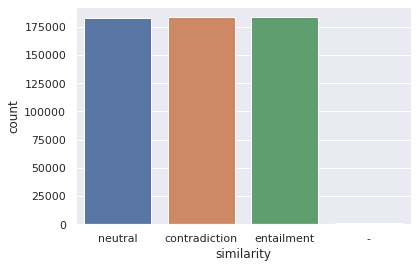

In [10]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="similarity", data=train_df)

In [11]:
train_df.loc[train_df['similarity'] == 'neutral']

,similarity,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
3,neutral,Children smiling and waving at camera,They are smiling at their parents
8,neutral,A boy is jumping on skateboard in the middle o...,The boy is wearing safety equipment.
9,neutral,An older man sits with his orange juice at a s...,An older man drinks his juice as he waits for ...
11,neutral,An older man sits with his orange juice at a s...,An elderly man sits in a small shop.
...,...,...,...
550137,neutral,A group of four kids stand in front of a statu...,the kids are black
550142,neutral,a kid doing tricks on a skateboard on a bridge,a kid is on the golden gate bridge
550145,neutral,A dog with a blue collar plays ball outside.,a dog is chasing a ball
550148,neutral,Four dirty and barefooted children.,"four homeless children had their shoes stolen,..."


# 3. Create new training, validation and test data sets

## 3.1. New training data

In [12]:
# Train data
contradiction_train_df = train_df.loc[train_df['similarity'] == 'contradiction']
contradiction_train_df = contradiction_train_df.iloc[:91707]

neutral_train_df = train_df.loc[train_df['similarity'] == 'neutral']
neutral_train_df = neutral_train_df.iloc[:91707]

entailment_train_df = train_df.loc[train_df['similarity'] == 'entailment']
entailment_train_df = entailment_train_df.iloc[:183414]

train_df = pd.concat([contradiction_train_df, neutral_train_df, entailment_train_df])
train_df = train_df.sample(frac = 1)
train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if (x == "contradiction" or x == "neutral") else 1
)

train_labels = tf.keras.utils.to_categorical(train_df.label, num_classes=2)

train_df[['similarity']].value_counts()

similarity   
entailment       183414
contradiction     91707
neutral           91707
dtype: int64

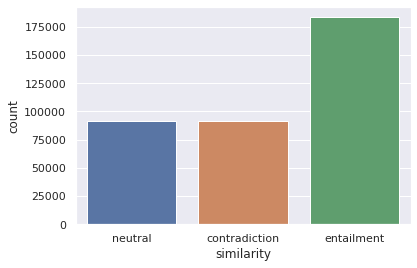

In [13]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="similarity", data=train_df)

## 3.2. New validation data

In [14]:
# Validation data
contradiction_valid_df = valid_df.loc[valid_df['similarity'] == 'contradiction']
contradiction_valid_df = contradiction_valid_df.iloc[:1664]

neutral_valid_df = valid_df.loc[valid_df['similarity'] == 'neutral']
neutral_valid_df = neutral_valid_df.iloc[:1664]

entailment_valid_df = valid_df.loc[valid_df['similarity'] == 'entailment']
entailment_valid_df = entailment_valid_df.iloc[:3328]

valid_df = pd.concat([contradiction_valid_df, neutral_valid_df, entailment_valid_df])
valid_df = valid_df.sample(frac = 1)
valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 0 if (x == "contradiction" or x == "neutral") else 1
)
valid_labels = tf.keras.utils.to_categorical(valid_df.label, num_classes=2)

valid_df[['similarity']].value_counts()

similarity   
entailment       3328
contradiction    1664
neutral          1664
dtype: int64

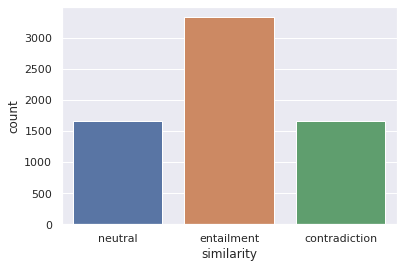

In [15]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="similarity", data=valid_df)

## 3.3. New test data

In [16]:
# Test data
contradiction_test_df = test_df.loc[test_df['similarity'] == 'contradiction']
contradiction_test_df = contradiction_test_df.iloc[:1684]

neutral_test_df = test_df.loc[test_df['similarity'] == 'neutral']
neutral_test_df = neutral_test_df.iloc[:1684]

entailment_test_df = test_df.loc[test_df['similarity'] == 'entailment']
entailment_test_df = entailment_test_df.iloc[:3368]

test_df = pd.concat([contradiction_test_df, neutral_test_df, entailment_test_df])
test_df = test_df.sample(frac = 1) 
test_df["label"] = test_df["similarity"].apply(
    lambda x: 0 if (x == "contradiction" or x == "neutral") else 1
)

test_labels = tf.keras.utils.to_categorical(test_df.label, num_classes=2)

test_df[['similarity']].value_counts()

similarity   
entailment       3368
contradiction    1684
neutral          1684
dtype: int64

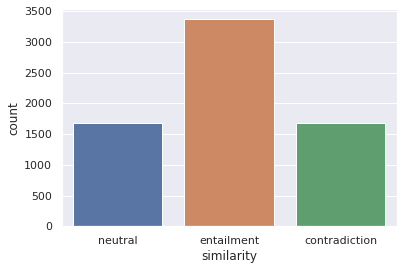

In [17]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="similarity", data=test_df)

# 4. Tokenizer

In [18]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 2

# Labels in our dataset.
labels = ["Incorrect", "Correct"]

In [19]:

class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            truncation=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)


# 5. Create the model

In [20]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_outputs = bert_model(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    last_hidden_state = bert_outputs[0]
    
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(last_hidden_state)
    dense_layer_1 = tf.keras.layers.Dense(32, activation="sigmoid")(avg_pool)
    dropout = tf.keras.layers.Dropout(0.5)(dense_layer_1)
    output = tf.keras.layers.Dense(2, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/ta

In [21]:
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    train_labels,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    valid_labels,
    batch_size=batch_size,
    shuffle=False,
)

# 6. Train model

In [22]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [23]:
time_callback = TimeHistory()

In [24]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
    callbacks = [time_callback]
)

Epoch 1/2


/home/tr92346-local/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
11463/11463 [==============================] - 1962s 170ms/step - loss: 0.6015 - acc: 0.6710 - val_loss: 0.4854 - val_acc: 0.7692
Epoch 2/2
11463/11463 [=======

In [25]:
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'pre-trained-bert-feature-extractor-history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [26]:
hist_time_df = pd.DataFrame(time_callback.times) 
hist_csv_file = 'pre-trained-bert-feature-extractor-time.csv'
with open(hist_csv_file, mode='w') as f:
    hist_time_df.to_csv(f)

In [27]:
model.save_weights('./pre-trained-bert-feature-extractor.h5')

# 7. Fine-tuning model

In [28]:
# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0]        

In [29]:
time_callback = TimeHistory()

In [30]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
    callbacks = [time_callback]
)

Epoch 1/2
11463/11463 [==============================] - 5083s 442ms/step - loss: 0.3085 - accuracy: 0.8795 - val_loss: 0.1898 - val_accuracy: 0.9301
Epoch 2/2
11463/11463 [==============================] - 5066s 442ms/step - loss: 0.2011 - accuracy: 0.9279 - val_loss: 0.2212 - val_accuracy: 0.9327


In [31]:
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'pre-trained-bert-history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [32]:
hist_time_df = pd.DataFrame(time_callback.times) 
hist_csv_file = 'pre-trained-bert-time.csv'
with open(hist_csv_file, mode='w') as f:
    hist_time_df.to_csv(f)

In [33]:
model.save_weights('./pre-trained-bert.h5')

# 8. Evaluate model on the test set

In [34]:
test_data = BertSemanticDataGenerator(
    test_df[["sentence1", "sentence2"]].values.astype("str"),
    test_labels,
    batch_size=batch_size,
    shuffle=False,
)
model.evaluate(test_data, verbose=1)

210/210 [==============================] - 32s 152ms/step - loss: 0.2424 - accuracy: 0.9265


[0.24242542684078217, 0.9264881014823914]

# 9. Custom data evaluation

In [35]:
def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data)[0]
    return {'Incorrect': proba[0], 'Correct': proba[1]}

In [36]:
sentence1 = "Two women are observing something together."
sentence2 = "Two women are observing something together."
check_similarity(sentence1, sentence2)

{'Incorrect': 0.039951432, 'Correct': 0.9600486}

In [37]:
sentence1 = 'A group of kids is playing in a yard and an old man is standing in the background'
sentence2 = 'A group of boys in a yard is playing and a man is standing in the background'
check_similarity(sentence1, sentence2)

{'Incorrect': 0.6693807, 'Correct': 0.3306193}

In [38]:
sentence1 = 'A distributed system is a system from multiple computers which communicate with each other via network'
sentence2 = 'A distributed system is a system from one computer without network'
check_similarity(sentence1, sentence2)

{'Incorrect': 0.9974874, 'Correct': 0.0025125437}

In [39]:
sentence1 = 'Bubble sort is a simple sorting algorithm that repeatedly steps through the list, compares adjacent elements and swaps them if they are in the wrong order.'
sentence2 = 'Bubble sort is circle of people'
check_similarity(sentence1, sentence2)

{'Incorrect': 0.9941438, 'Correct': 0.005856231}

In [40]:
sentence1 = "Microservice architecture – a variant of the service-oriented architecture (SOA) structural style – arranges an application as a collection of loosely coupled services. In a microservices architecture, services are fine-grained and the protocols are lightweight."
sentence2 = "Microservice architecture is an art, which has one person"
check_similarity(sentence1, sentence2)

{'Incorrect': 0.9834305, 'Correct': 0.016569478}

In [41]:
sentence1 = "People are sitting there. They are watching football"
sentence2 = "People are standing there to watch football"
check_similarity(sentence1, sentence2)

{'Incorrect': 0.99998426, 'Correct': 1.5696658e-05}

In [42]:
sentence1 = "A distributed system is a system whose components are located on different networked computers, which communicate and coordinate their actions by passing messages to one another from any system. The components interact with one another in order to achieve a common goal. Three significant characteristics of distributed systems are: concurrency of components, lack of a global clock, and independent failure of components. Examples of distributed systems vary from SOA-based systems to massively multiplayer online games to peer-to-peer applications."
sentence2 = "A distributed system is a system from one computer without network"
check_similarity(sentence1, sentence2)

{'Incorrect': 0.672034, 'Correct': 0.327966}

In [43]:
sentence1 = "A beautiful girl is sitting there"
sentence2 = "A distributed system is a system from one computer without network"
check_similarity(sentence1, sentence2)

{'Incorrect': 0.98910284, 'Correct': 0.010897157}